# **KalMax** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/KalMax/blob/main/kalmax_demo.ipynb)

In this script we demonstrate how to use the KalMax library. We will: 

0. Load/generate some exemplar spiking and trajectory data .
1. Fit KDE receptive fields to the spiking data.
2. Run inference (decode position from held-out spikes) by: 
    1. Estimate likelihood maps using the receptive fields. 
    2. Kalman filter (and smooth) the modes of the likelihood maps (ML) to estimate the trajectory.

In [1]:
# Import kalmax (download if not installed)
try: import kalmax 
except ImportError:
    !pip install git+https://github.com/TomGeorge1234/KalMax.git#egg=kalmax[demo]
    import kalmax

In [2]:
from kalmax import demo_utils

In [3]:
# Kalmax
from kalmax.kalman import KalmanFilter
from kalmax.kde import kde, poisson_log_likelihood
from kalmax.utils import make_simulated_dataset, fit_gaussian_vmap

# Dependencies
from jax import numpy as jnp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
time_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [[243/255,237/255,117/255],[243/255,218/255,117/255],[243/255,182/255,117/255],[247/255,159/255,117/259],[247/255,142/255,117/255],[247/255,108/255,117/255],[247/255,71/255,117/255]])
from tqdm import tqdm 
from time import time 

%load_ext autoreload
%autoreload 2

## 0. Generate / load data

The data is are:

* $\mathbf{x}_t \in \mathbb{R}^D$ is the position (more generally the "latent variable") at time $t$,
* $\mathbf{s}_t \in \mathbb{N}^{N_{\textrm{cells}}}$  is the vector of spike counts for all $N_{\textrm{cells}}$ neurons at time $t$,

for $t = 1, \ldots, T$. These are concatenated into data arrays: $\mathbf{X} \in \mathbb{R}^{T \times D}$ and $\mathbf{S} \in \mathbb{N}^{T \times N_{\textrm{cells}}} $

<img src="./figures/display_figures/input_data.png" width=750>


### 0.1 Artifical place cell data
For this demo we'll generate some artificial place cell data (using the [RatInABox](https://github.com/RatInABox-Lab/RatInABox) package). The agent moves around a 1 x 1 meter box under a smooth random motion policy. Each place cell has a small Gaussian receptive field determining when the cell spikes as a function of the agent's position.

In [4]:
#GLOBALS
TIME_MINS = 20 # total amount of data to generate in minutes
N_CELLS = 100 # number of cells to simulate
FIRING_RATE = 10 # firing rate of the cells

# This function generates a simulated dataset of place cells, you can find it in the utils.py file
T, X, S = make_simulated_dataset(time_mins = TIME_MINS, 
                                 n_cells = N_CELLS,
                                 firing_rate = FIRING_RATE,) #alternatively you can load some real data here

# Print the shapes of the data
print(f"Shapes:\n  •Time, T {T.shape}\n  •Trajectory, X: {X.shape}\n  •Spikes, S: {S.shape}")

# Define some other useful variables
DIMS = X.shape[1] # Number of dimensions, should be 2 in this demo 
N_W = min(10,N_CELLS) # width of multipanel plots 
N_H = int(np.ceil(N_CELLS/N_W)) # height of multipanel plot
DT = T[1] - T[0]

100%|██████████| 12000/12000 [00:04<00:00, 2915.12it/s]


Shapes:
  •Time, T (12000,)
  •Trajectory, X: (12000, 2)
  •Spikes, S: (12000, 100)


### 0.2 Test-train split
We'll split the data into a training set (for fitting the receptive fields) and a test set (for decoding the trajectory).

In [5]:
# GLOBALS
TEST_MINS = 3 # amount of data to use for testing in minutes

# Split data into training and testing
split = jnp.argmin(jnp.abs(T - (T[-1] - TEST_MINS * 60)))
T_train, T_test = T[:split], T[split:]
S_train, S_test = S[:split], S[split:]
X_train, X_test = X[:split], X[split:]

### 0.3 Pad the data, calculate it's extent and discretise the domain

We generate a grid of position coordinates bins spanning the D-dimensional domain of the latent space. These are the bins over which we will estimate the receptive fields. We flatten them into a list but record the original shape so we can later visualise the receptive fields. (You may adapt this to a D $\neq$ 2-dimensional latent accordingly)

_Note the discretisation is only applied for calculating the receptive fields and not position decoding which is fully-continuous. Also note we use `'ij'` indexing for making the grid with `np.meshgrid` which is not the default but generalises better to higher dimensional settings. It puts `x` along the first axis and `y` along the second, so we will need to transpose and reverse the ratemaps before plotting._

* `bin_positions` is an array of positions shape `(N_bins, D)` spanning the full domain of the data (plus a little bit). 
* `bin_shape` is a tuple `(n_x_bins, n_y_bins)` for reshapping the grid_positions array into a grid.

<img src="./figures/display_figures/env_discretisation.png" width=1200>



In [6]:
# GLOBALS
DX = 0.02 # resolution of receptive field estimates in meters
PAD = 0.02 # padding around the trajectory in meters

# Get max and min data positions
min_x, max_x = X_train[:,0].min() - PAD, X_train[:,0].max() + PAD
min_y, max_y = X_train[:,1].min() - PAD, X_train[:,1].max() + PAD
env_extent = (min_x, max_x, min_y, max_y)


# Make a grid of positions to evaluate the receptive fields
x = jnp.arange(min_x, max_x+DX, DX) 
y = jnp.arange(min_y, max_y+DX, DX)
bin_coords = jnp.stack(jnp.meshgrid(x, y, indexing='ij'), axis=0) # X is the first dimension, Y is the second dimension (for plotting)
bin_positions = jnp.reshape(bin_coords, (DIMS, -1)).T; # x is first coordinate, y is second coordinate
bin_shape = bin_coords.shape[1:] # so we can reshape the receptive fields later

print(f"Environment created from data x = {min_x:.2f} to {max_x:.2f} y = {min_y:.2f} to {max_y:.2f}. The resolution is {DX:.2f} meters and discretised shape is (n_x_bins, n_y_bins) = {bin_shape}")

Environment created from data x = -0.02 to 1.02 y = -0.02 to 1.02. The resolution is 0.02 meters and discretised shape is (n_x_bins, n_y_bins) = (53, 53)


### 0.4.1 Plot the trajectory

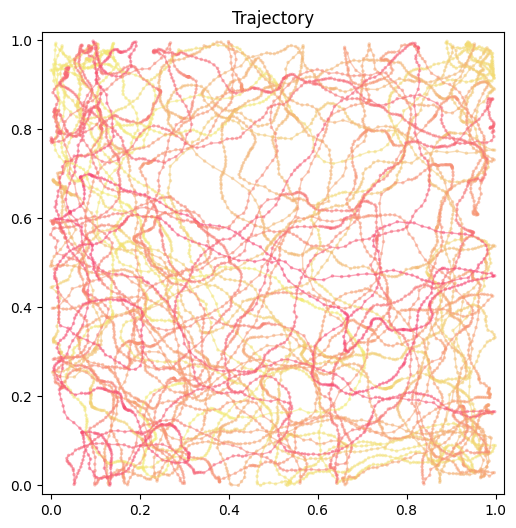

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6)) 
lc = LineCollection(np.concatenate([X_train[:-1,None], X_train[1:,None]], axis=1), cmap=time_cmap, norm=plt.Normalize(0, T_train[-1]), linewidth=1)
lc.set_array(T_train)
lc.set_alpha(0.5)
ax.add_collection(lc)
ax.scatter(X_train[:,0], X_train[:,1], c=time_cmap(T_train/T_train[-1]),s=6,linewidth=0, alpha=0.5)
ax.set_xlim(min_x, max_x); ax.set_ylim(min_y, max_y); ax.set_aspect('equal', 'box')
ax.set_title("Trajectory");
# fig.savefig("figures/trajectory.png")

### 0.4.2 Plot the spikes against the trajectory

In [8]:
fig = plt.figure(figsize=(N_W*3 + 1, N_H*3))
for i in range(N_CELLS):

    # Get spike positions
    x_spike_positions = X_train[:,0][S_train[:,i] > 0]
    y_spike_positions = X_train[:,1][S_train[:,i] > 0]
    colors = time_cmap(T_train[S_train[:,i] > 0]/T_train[-1])

    # Plot the spikes
    ax = fig.add_subplot(N_H, N_W, i+1, xticks=[], yticks=[])
    ax.scatter(x_spike_positions, y_spike_positions, s=6, linewidth=0, alpha=0.7, c=colors)
    ax.set_title(f"Cell {i}")
    ax.set_xlim(min_x, max_x); ax.set_ylim(min_y, max_y); ax.set_aspect('equal', 'box')
    if i == 0:
        ax.set_xticks([min_x.round(1), max_x.round(1)]); ax.set_yticks([min_y.round(1), max_y.round(1)])
        
fig.suptitle("Spike rasters", y=0.92)

Text(0.5, 0.92, 'Spike rasters')

## 1. **KDE** to fit receptive fields 

We will use **kernel density estimation** to fit the receptive fields. KDE is a way of converting discrete events to smooth functions.

Let $\mathbf{f}(\mathbf{x}) = [f_1(\mathbf{x}), \cdots f_N(\mathbf{x})]^{\mathsf{T}}$ be the vector of _expected_ spike counts for each neuron at position $\mathbf{x}$ (i.e. the receptive fields) which we want to estimate from the data.


The KDE estimate of the receptive field for neuron $i$ is:
$$f_i(\mathbf{x}) = \frac{\sum_{t_s} K(\mathbf{x}, \mathbf{x}_{t_s^{(i)}}) }{\sum_{t} K(\mathbf{x}, \mathbf{x}_{t})}$$
where $t_s^{(i)}$ are the times when neuron $i$ spiked.
The basic idea is that the _expected_ number of spikes is the no. of spikes at that location x divided by the total no. of visits to that location. 

$K(\mathbf{x}, \mathbf{x}^{\prime})$ is any kernel function. We will use a Gaussian with covariance $\boldsymbol{\Sigma} = \sigma^2 \mathbf{I}$:

$$K_{\textrm{Gaussian}}(\mathbf{x}, \mathbf{x}^{\prime}) = \frac{1}{(2\pi)^{D/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mathbf{x}^{\prime})^{\mathsf{T}} \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \mathbf{x}^{\prime})\right)$$

Now we estimate the receptive fields by passing the bins, the trajectory and the spikes and a kernel into the `KDE.kde()` function.

In [9]:
# GLOBALS
KERNEL = kalmax.kernels.gaussian_kernel # the kernel function - you can write your own but it must follow a certain signature
KERNEL_BANDWIDTH = 0.02 # width of the smoothing kernel in meters

# Calculate the firing rate of all cells at all grid positions
firing_rate = kde(
    bins = bin_positions,
    trajectory = X_train,
    spikes = S_train,
    kernel = KERNEL,
    kernel_bandwidth = KERNEL_BANDWIDTH,
)

# Reshape into receptive fields and divide by DT to get expected spikes per second (not per time bin) 
firing_rate_maps = firing_rate.reshape((N_CELLS,)+bin_shape) / DT 

print(f"The maximum measured firing rate across all cells is {firing_rate_maps.max():.2f} Hz")

The maximum measured firing rate across all cells is 10.00 Hz


### 1.1 Plot the fitted receptive fields 
Remember to reshape the receptive fields back to the original grid shape for plotting. This has x increasing on axis 0 and y increasing on axis 1 so we need to transpose and reverse the receptive fields.

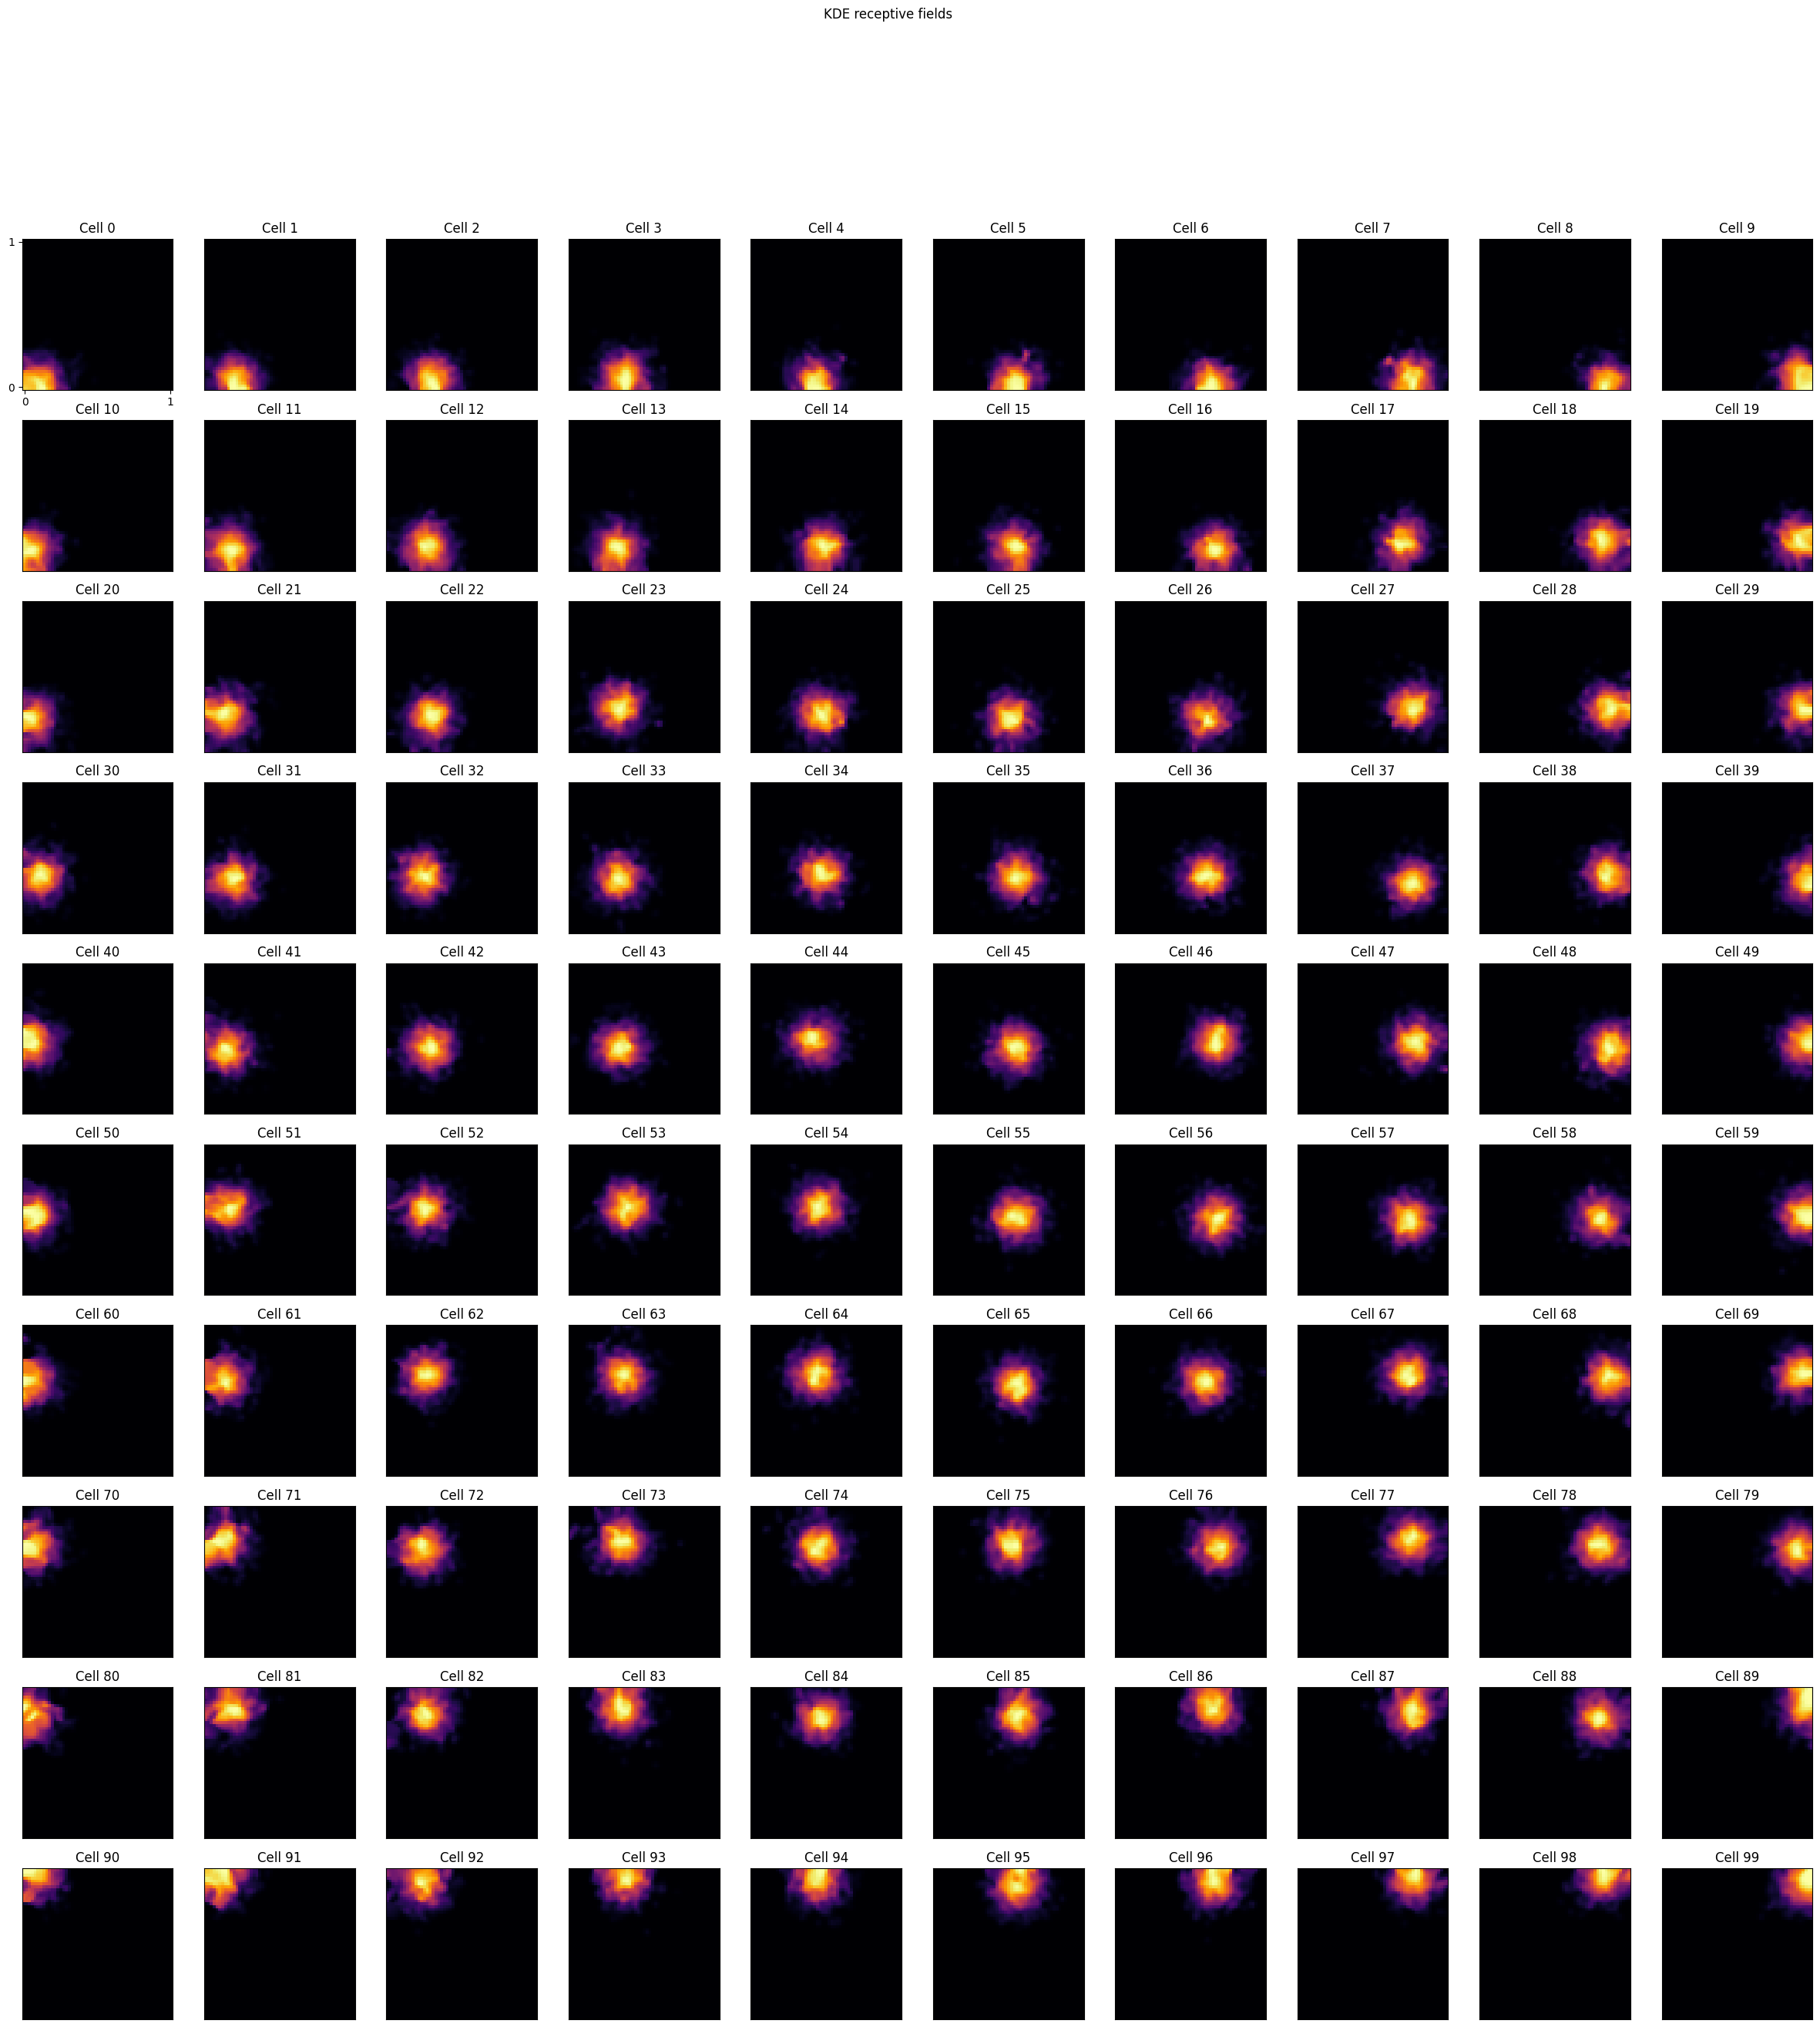

In [10]:
fig = plt.figure(figsize=(N_W*3, N_H*3))
for i in range(N_CELLS):

    # Get the firing rate map
    rate_map = firing_rate_maps[i].T[::-1,:] # flip and reverses so axes x-dim is left to right and y-dim is bottom to top

    # Plot the firing rate map
    ax = fig.add_subplot(N_H, N_W, i+1, xticks=[], yticks=[])
    ax.imshow(rate_map, extent=env_extent, cmap='inferno', vmin=0)
    ax.set_title(f"Cell {i}")
    ax.set_xlim(min_x, max_x); ax.set_ylim(min_y, max_y); ax.set_aspect('equal', 'box')
    if i == 0:
        ax.set_xticks([min_x.round(1), max_x.round(1)]); ax.set_yticks([min_y.round(1), max_y.round(1)])
fig.suptitle("KDE receptive fields");
# fig.savefig("figures/receptive_fields.png")

## 2. **Kalman filter** to decode position from test spikes

...using these receptive fields (fitted on the training data) to decode position from test spikes. There are two steps: 

1. From the spikes calculate the likelihood maps.
2. Fit Gaussians to these. 
2. Use these the mean and variances of these Gaussians as the state observations in the Kalman filter.


### 2.1 Calculate likelihoods maps

To calculate the likelihoods we use the `poisson_log_likelihood` function. This takes in the spiking data (shape `(T, N_cells)`), the firing rate maps (shape `(N_cells, N_bins)`) and returns the log-likelihoods (shape `(T, N_bins)`) of the spikes at each time step and each position bin.

The likelihood of observing $s$ spikes in a time bin given the expected number of spikes $f$ is:

$$P(s | f) = \frac{f^s e^{-f}}{s!}$$

so the total log-likelihood of observing the spikes at a position $\mathbf{x}$ is found by summing the likelihoods over all neurons:

$$\log P(\mathbf{s} | \mathbf{z}) = \sum_{i=1}^{N_\textrm{cells}} \log P(s_i | f_i(\mathbf{z}))$$

These can then be reshaped using the `bin_shape` variable to plot the likelihoods as maps. 

In [11]:
# Calculate the likelihood of the test spikes given the firing rate at each grid position
log_likelihoods = poisson_log_likelihood(spikes=S_test, mean_rate=firing_rate) # shape (T, N_bins)
likelihoods = jnp.exp(log_likelihoods) # shape (T, N_bins)
likelihood_maps = likelihoods.reshape((likelihoods.shape[0],)+bin_shape) # shape (T, N_x_bins, N_y_bins)



### 2.2 Plot the likelihood maps 
Coloured dots show the _true_ position of the agent at each timestep. Grey colomaps show the combined likelihood of the observed spikes at each time step.

/var/folders/kl/5cmzc25n1_jdp8v6cklmpzm80000gn/T/ipykernel_18687/401973497.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_test[5*i,0], X_test[5*i,1], s=15, c=time_cmap(i/10), label="True position")


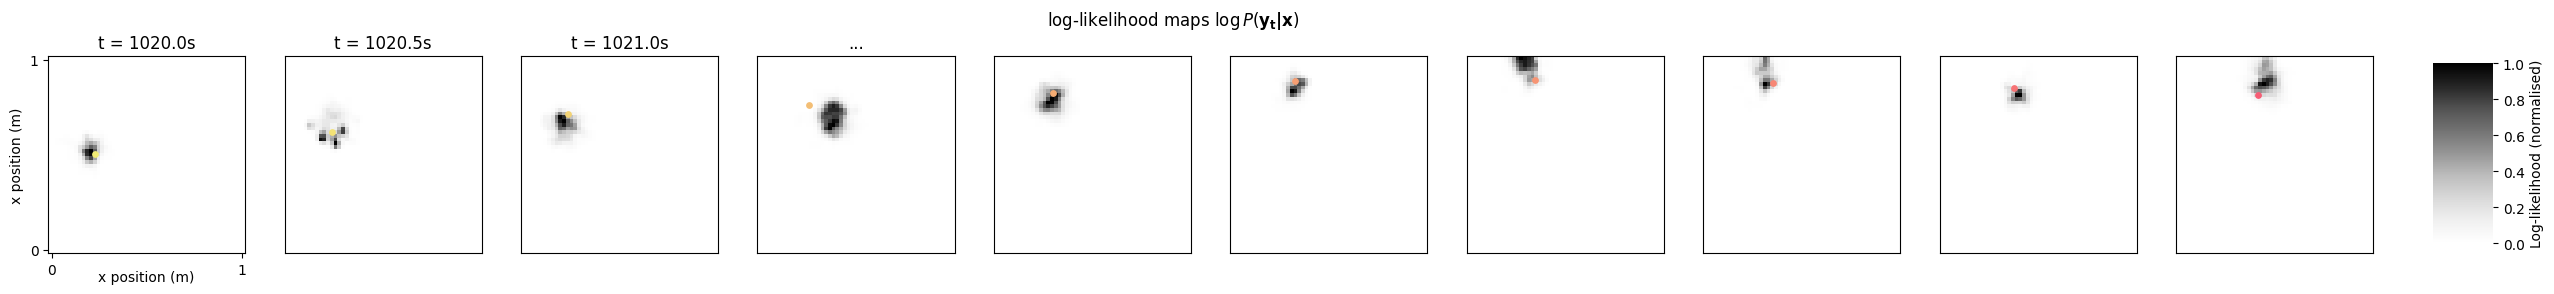

In [12]:
# Plot them (only show every 5th time point)
fig = plt.figure(figsize=(30, 3))
for i in range(0,10):
    likelihood_map = likelihood_maps[5*i].T[::-1] # <-- transposes and reverses so y-axis now run from bootm-left to top-left of the array

    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    im = ax.imshow(likelihood_map, extent=env_extent, cmap='Greys', aspect='equal')
    ax.scatter(X_test[5*i,0], X_test[5*i,1], s=15, c=time_cmap(i/10), label="True position")
    ax.set_title(f"{f't = {T_test[5*i]:.1f}s' if i <= 2 else f'{'...' if i == 3 else ''}'}")
    if i == 0:
        ax.set_xticks([min_x.round(1), max_x.round(1)]); ax.set_yticks([min_y.round(1), max_y.round(1)])
        ax.set_xlabel("x position (m)", labelpad=-5); ax.set_ylabel("x position (m)")
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6], frameon=False)
fig.colorbar(im, cax=cax, label="Log-likelihood (normalised)");
fig.suptitle(r"log-likelihood maps $\log P(\mathbf{y_{t} | \mathbf{x}})$");

### 2.3 Fit Gaussians to likelihoods

The goal is to approximate these (potentially complex and multimodal) likelihood maps with a Gaussian: 

$$P(\mathbf{s}_{t} | \mathbf{x}) \approx  A \exp\Big[{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu}_t)^{\mathsf{T}}\boldsymbol{\Sigma}_{t}^{-1}(\mathbf{x}-\boldsymbol{\mu}_t)}\Big]$$

**Why are we doing this?** In the next section we want to use a Kalman filter to _estimate_ position from spiking data. A core assumption of the Kalman model is the "observations" of a system are (noisy) linear functions of the state. This is not true (or at least not a very good assumption) for spike counts, instead but probably is for the mode of the likelihood maps may approximately be. 

_Special case:_ When there are _no_ spikes, the likelihood maps provide almost zero information about the position but the Gaussian fit will still have a constant mean, mode and variance. To prevent this biasing the Kalman filter we will artificially inflate the variance of the Gaussian fit when there are no spikes.

In [13]:
# Calculate the means, modes and covariances of the fitted Gaussians
ML_means, ML_modes, ML_covs = fit_gaussian_vmap(bin_positions, likelihoods)

# add large variance to bins where there are _no_ spikes
ML_covs = ML_covs + 1e6*jnp.eye(DIMS)[None,...] * (S_test.sum(axis=1)==0)[...,None,None] 

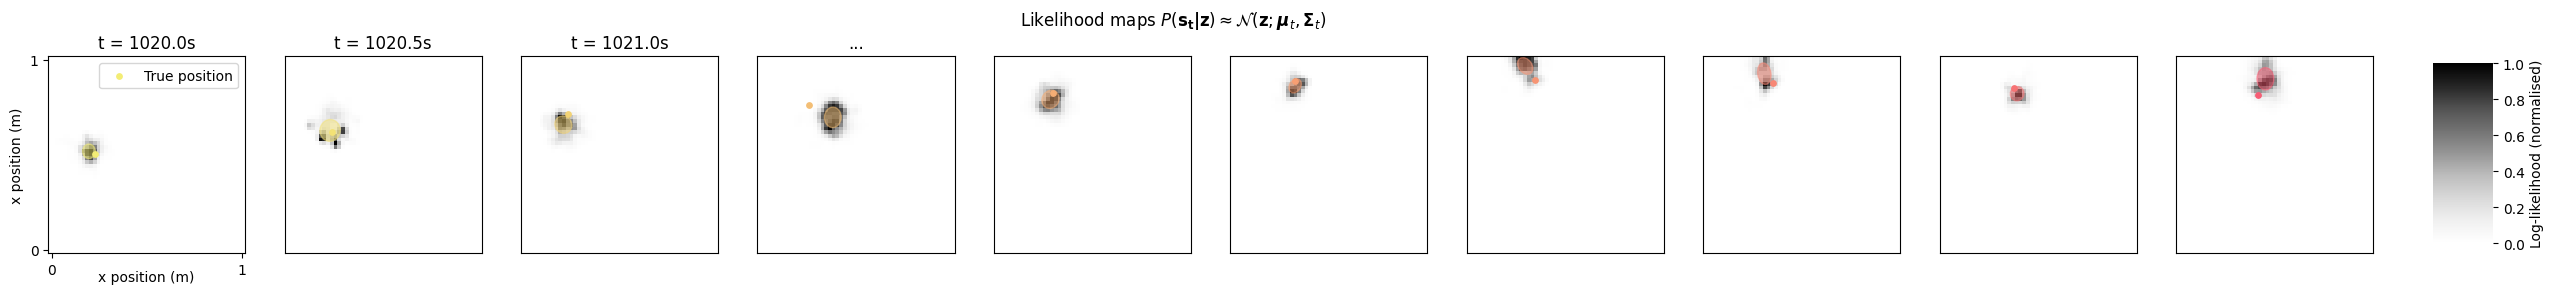

In [14]:
for (i,ax) in enumerate(fig.get_axes()[:-1]):
    lambda_, v = np.linalg.eig(ML_covs[5*i])
    lambda_ = np.sqrt(lambda_) # convert from variance to standard deviation along the eigenvectors
    ax = kalmax.demo_utils.plot_ellipse(ax, mean=ML_means[5*i], cov=ML_covs[5*i], color=time_cmap(i/10))
    if i == 0:
        ax.legend(loc='upper right')
fig.suptitle(r"Likelihood maps $P(\mathbf{s_{t} | \mathbf{z}}) \approx \mathcal{N}(\mathbf{z} ; \boldsymbol{\mu}_t, \boldsymbol{\Sigma}_t)$")
# fig.savefig("figures/likelihood_maps_fitted.png", dpi=300)
fig

### 2.4 Inference via Kalman filter
Let $\mathbf{z}_t$ represents the "state" of the system (its latent position) and assume it evolves according to a linear dynamical system with Gaussian noise. $\mathbf{y}_t$ represents an "observation" of the system and is a noisy linear function of the state:
$$\mathbf{z}_{t} = \mathbf{F}_t \mathbf{z}_{t-1} + \mathbf{q}_t$$
$$\mathbf{y}_{t} = \mathbf{H}_t \mathbf{z}_{t} + \mathbf{r}_t$$
where $\mathbf{q}_t \sim \mathcal{N}(0, \mathbf{Q}_t)$ and $\mathbf{r}_t \sim \mathcal{N}(0, \mathbf{R}_t)$ are the process and observation noises respectively. 

The Kalman filter is an efficient recursive solution to the problem of estimating the posterior distribution of the state given the observations. Since the initial state distribution is Gaussian and the dynamics / observation models are linear with Gaussian noise, the _posterior_ distribution at each time step is also Gaussian and can be computed recursively very fast using the Kalman filter equations (can be found in any textbook, I match the notation to [Chapter 8.2, Probabilistic Machine Learning (Advanced Topics), Kevin Murphy](https://probml.github.io/pml-book/book2.html)). 

Strictly, Kalman "filtering" calculates the posterior distribution of the state given only the observations up to that time. Kalman "smoothing" calculates the posterior distribution of the state given all the observations.

$$P(\mathbf{z}_t | \mathbf{y}_{1:t}) = \mathcal{N}(\mathbf{z}_t | \boldsymbol{\mu}^{F}_t, \boldsymbol{\Sigma}^{F}_t)$$
$$P(\mathbf{z}_t | \mathbf{y}_{1:T}) = \mathcal{N}(\mathbf{z}_t | \boldsymbol{\mu}^{S}_t, \boldsymbol{\Sigma}^{S}_t)$$

### 2.5 KalMax: Kalman smoothing naive Bayes

The basic idea here is to combine the benefits of maximum likelihood decoding with Kalman smoothing by using the modes of the likelihood maps as the observations in the Kalman filter. In this manner spikes are not _directly_ used as observations in the Kalman filter bypassing the issue of non-linearity.


$$\mathbf{y}_t = \mathbf{x}_t^{\textrm{ML}} := \arg\max_{\mathbf{x}} P(\mathbf{s}_t | \mathbf{x})$$


The parameters of the Kalman filters are set as: 

\begin{align}
\mathbf{F} &= \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \\
\mathbf{Q} &= \begin{pmatrix} \sigma_{v}^2 & 0 \\ 0 & \sigma_{v}^2 \end{pmatrix} \\
\mathbf{H} &= \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} \\
\mathbf{R}_t &= \begin{pmatrix} \sigma_{o}^2 & 0 \\ 0 & \sigma_{o}^2 \end{pmatrix} + \boldsymbol{\Sigma}_t
\end{align}

where $\sigma_{v} = v_{\textrm{typical}} \cdot dt$ and $\sigma_{o}$ are priors on the speed of the agent and the observation noise respectively. We could "fit" these parameters but instead we'll just set them to reasonable values.
The observation noise has a fixed term (assume all maximum likelihood estimates are noisy) and a time varying term (assume maximum likelihood estimates with broad likelihoods are _more_ uncertain). This is not a rigorously justified model but it works well in practise: intuitvely it allows the Kalman filter to "trust" the likelihood maps more when they are more certain (e.g. because there are more spikes, or the spikes came from more spatially informative neurons).

#### 2.5.1 `KalmanFilter` class
The `KalmanFilter` has two primary functions: 
* `KalmanFilter.filter(Y)` takes in the observations $\mathbf{Y} \in \mathbb{R}^{T \times D_{\textrm{Y}}}$ and returns the means and covariances of the posterior distribution at each time step.
* `KalmanFilter.smooth(mus_f, sigmas_f)` takes in the filtered means ($\in \mathbb{R}^{T \times D}$) and covariances ($\in \mathbb{R}^{T \times D \times D}$) and returns the _smoothed_ means and covariances of the posterior distribution at each time step.
To set the parameters $\Theta = \{ \boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0, \mathbf{F}, \mathbf{Q}, \mathbf{H}, \mathbf{R} \}$ you can either pass them in as arguments to the `KalmanFilter`  initialisation or pass them in at the time of calling the `filter` and `smooth` functions. In the former case they are assumes to be stationary and in the latter case they can be time-varying along an additional 0-th axis.

In [15]:
# Priors 
v_typical = 0.2 # typical velocity in m/s (sets the scale of the smoothing prior)
sigma_speed = v_typical * DT 
sigma_obs = 0.05 # (units meters) standard deviation of the fixed observation noise

# Fit the parameters
mu0 = jnp.array([(max_x-min_x)/2, (max_y-min_y)/2]) # initial mean
sigma0 = jnp.eye(DIMS) * 1.0 # initial covariance (very broad)
F = jnp.eye(DIMS) # transition matrix
Q = jnp.eye(DIMS) * sigma_speed**2 # transition covariance
H = jnp.eye(DIMS) # observation matrix
R = jnp.eye(DIMS) * sigma_obs**2 # observation covariance

In [16]:
# Create the Kalman Filter
kalman_filter = KalmanFilter(dim_Z = DIMS, 
                             dim_Y = DIMS,
                             F=F, 
                             Q=Q, 
                             H=H,
                             R=None, # R is time varying so we don't set it here
                             )

# (benchmark speed against Pykalman)

In [17]:
from pykalman import KalmanFilter as PyKalmanFilter
import numpy as np
from time import time

# PYKALMAN
kf = PyKalmanFilter(transition_matrices = np.array(F),
                  observation_matrices = np.array(H),
                  transition_covariance = np.array(Q),
                  observation_covariance = np.array(R),
                  initial_state_mean = np.array(mu0),
                  initial_state_covariance = np.array(sigma0),
                  )

t0 = time()
ma, sa = kf.filter(np.array(ML_modes))
print(f"PyKalmanFilter took {time()-t0:.2f}s")

# Create the Kalman Filter
kf = KalmanFilter(dim_Z = DIMS, 
                  dim_Y = DIMS,
                  F=F, 
                  Q=Q, 
                  H=H,
                  R=R,
                )
t0 = time()
mb, sb = kf.filter(
                     Y = ML_modes, # <-- maximum likelihood positions used as observations 
                     mu0 = mu0,
                     sigma0=sigma0,
                     )
print(f"KalmanFilter took {time()-t0:.2f}s")

PyKalmanFilter took 0.11s
KalmanFilter took 0.31s


#### 2.4.2 Filtering and smoothing

Text(0.5, 1.0, 'KalMax Kalman smoothed trajectory')

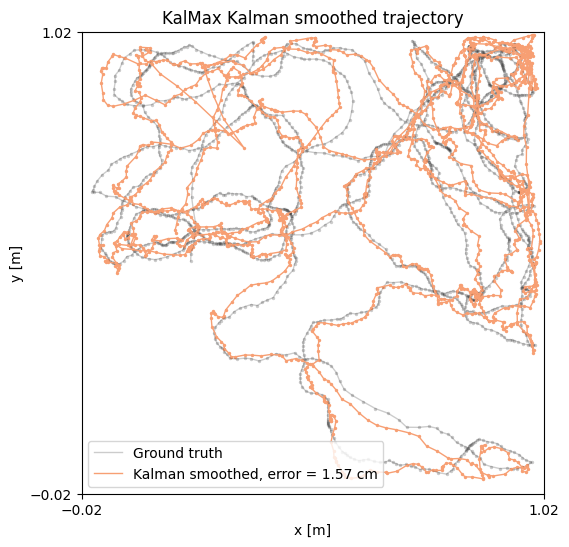

In [18]:
# Set the observation noise covariance
R = 0.*ML_covs + (sigma_obs**2)*jnp.eye(DIMS) 

# Filter the test observations 
mus_f, sigmas_f = kalman_filter.filter(
                     Y = ML_modes, # <-- maximum likelihood positions used as observations 
                     mu0 = mu0,
                     sigma0 = sigma0,
                     R=R
                     )

# Smooth the test observations 
mus_s, sigmas_s = kalman_filter.smooth(
                    mus_f = mus_f, 
                    sigmas_f = sigmas_f)


# Plot the results
ax = kalmax.demo_utils.plot_trajectory(
    ax=None, 
    trajectory=X_test, 
    time_stamps=T_test,
    color='k', alpha=0.2, label="Ground truth",
    min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)
ax = kalmax.demo_utils.plot_trajectory(
    ax=ax, 
    trajectory=mus_s, 
    time_stamps=T_test, 
    color=time_cmap(0.5), label=f"Kalman smoothed, error = {100*jnp.abs(mus_s - X_test).mean():.2f} cm",
    min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)
ax.legend()
ax.set_title("KalMax Kalman smoothed trajectory")

## 3. Benchmarks 
### 3.1 Naive Kalman (benchmark 1)

<!-- For time-constant dynamics/observations the Kalman filter can be fit by maximum likelihood (exploiting/assuming the fact that $\mathbf{z}_t$ is known during training). The parameters $\Theta = \{\mathbf{F}, \mathbf{Q}, \mathbf{H}, \mathbf{R}\}$ which maximise the likelihood of the data under the model $\mathcal{L}(\Theta) = \log P(\mathbf{Y}, \mathbf{Z} | \Theta)$ are found to be:

\begin{align}
\mathbf{F} &= \Big( \sum_{t=2}^{T} \mathbf{z}_{t-1} \mathbf{z}_{t}^{\mathsf{T}} \Big) \Big( \sum_{t=2}^{T} \mathbf{z}_{t-1} \mathbf{z}_{t-1}^{\mathsf{T}} \Big)^{-1} \\
\mathbf{Q} &= \frac{1}{T-1} \sum_{t=2}^{T} (\mathbf{z}_{t} - \mathbf{F} \mathbf{z}_{t-1})(\mathbf{z}_{t} - \mathbf{F} \mathbf{z}_{t-1})^{\mathsf{T}} &\\
\mathbf{H} &= \Big( \sum_{t=1}^{T} \mathbf{z}_{t} \mathbf{y}_{t}^{\mathsf{T}} \Big) \Big( \sum_{t=1}^{T} \mathbf{y}_{t} \mathbf{y}_{t}^{\mathsf{T}} \Big)^{-1} & \\
\mathbf{R} &= \frac{1}{T} \sum_{t=1}^{T} (\mathbf{z}_{t} - \mathbf{H} \mathbf{y}_{t})(\mathbf{z}_{t} - \mathbf{H} \mathbf{y}_{t})^{\mathsf{T}}  
\end{align} -->

The most simple possible Kalman filter is one where the spikes are the observations. This is a very simple model - not making use of the receptive fields we just calculated at all - and is unlikely to work well in practice because the spikes are not linear functions of the position. 

\begin{align}
\textrm{Naive Kalman}:\\
\mathbf{z}_{t} = \mathbf{x}_{t} &\quad \textrm{(latent position)}\\
\mathbf{y}_{t} = \mathbf{s}_{t} &\quad \textrm{(spikes)}
\end{align}

For the parameters we can use the same $\mathbf{F}, \mathbf{Q}$ as before (these control the latent dynamics which haven't changed), but we need to refit $\mathbf{H}, \mathbf{R}$ to the spikes. For $\mathbf{H}$ we can calculate the optimal linear mapping from the latent position to the spikes (i.e. the kinear regression solution) and for $\mathbf{R}$ we can calculate the empirical covariance of the residuals:

\begin{align}
\mathbf{H} &= \Big( \sum_{t=1}^{T} \mathbf{z}_{t} \mathbf{y}_{t}^{\mathsf{T}} \Big) \Big( \sum_{t=1}^{T} \mathbf{y}_{t} \mathbf{y}_{t}^{\mathsf{T}} \Big)^{-1} & \\
\mathbf{R} &= \frac{1}{T} \sum_{t=1}^{T} (\mathbf{z}_{t} - \mathbf{H} \mathbf{y}_{t})(\mathbf{z}_{t} - \mathbf{H} \mathbf{y}_{t})^{\mathsf{T}}  
\end{align}

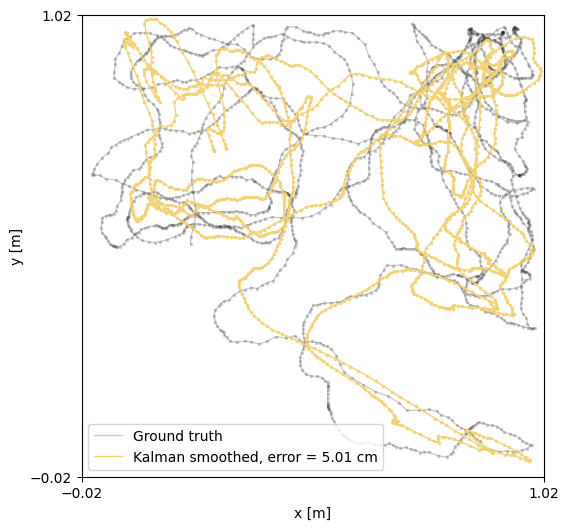

In [19]:
# Fit the parameters 
H = kalmax.kalman.fit_H(Z=X_train, Y=S_train)
R = kalmax.kalman.fit_R(Z=X_train, Y=S_train)

# Create the Kalman Filter
kalman_filter = KalmanFilter(dim_Z = DIMS, 
                             dim_Y = N_CELLS,
                             F=F, 
                             Q=Q, 
                             H=H,
                             R=R,
                            )

# Filter the test observations 
mus_f_naive, sigmas_f_naive = kalman_filter.filter(
                     Y = S_test, # <-- spikes used as observations
                     mu0 = mu0,
                     sigma0 = sigma0,)

# Smooth the test observations 
mus_s_naive, sigmas_s_naive = kalman_filter.smooth(
                    mus_f = mus_f_naive, 
                    sigmas_f = sigmas_f_naive)

# Plot the results
ax = kalmax.demo_utils.plot_trajectory(
    ax=None, 
    trajectory=X_test,
    time_stamps=T_test,
    color='k', alpha=0.2, label="Ground truth",
    min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)
ax = kalmax.demo_utils.plot_trajectory(
    ax=ax, 
    trajectory=mus_s_naive, 
    time_stamps=T_test, 
    color=time_cmap(0.2), label=f"Kalman smoothed, error = {100*jnp.abs(mus_s_naive - X_test).mean():.2f} cm",
    min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)
ax.legend()

### 3.2 Maximum likelihood estimates (benchmark 2)

Finally we can plot how well _just_ the maximum likelihood estimates perform (no Kalman filter). This is the simplest possible model and its pretty common in practise. The second issue is that the likelihoods are just very noisy (there aren't many neurons, and their Poisson spikes are only a noisy function of the position).

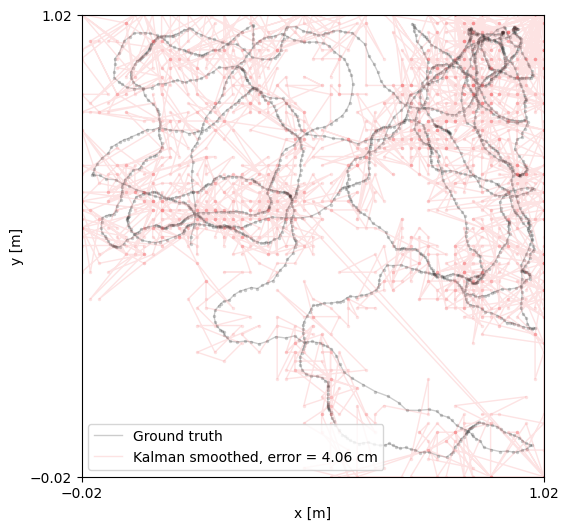

In [20]:
ax = kalmax.demo_utils.plot_trajectory(
    ax=None, 
    trajectory=X_test, 
    time_stamps=T_test,
    color='k', alpha=0.2, label="Ground truth",
    min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)
ax = kalmax.demo_utils.plot_trajectory(
    ax=ax, 
    trajectory=ML_modes, 
    time_stamps=T_test, 
    color=time_cmap(0.8), alpha=0.2, label=f"Kalman smoothed, error = {100*jnp.abs(ML_modes - X_test).mean():.2f} cm",
    min_x=min_x, max_x=max_x, min_y=min_y, max_y=max_y)
ax.legend()

## 4. Animating the results
(Some relative nasty code just to animate the results, you can ignore this)

In [47]:
def multipanel_plot(ax=None, t_start=None, t_end=None, trajectory=X_test, time_stamps=T_test):
    if ax is None: 
        fig, ax = plt.subplots(1,4,figsize=(18,4))
    else: assert len(ax) == 4
    if t_start is None: t_start = time_stamps[0]
    if t_end is None: t_end = time_stamps[-1]
    id_start, id_end = np.argmin(np.abs(time_stamps - t_start)), np.argmin(np.abs(time_stamps-t_end))
    trajectory = trajectory[id_start:id_end]

    # ax[0]: Ground truth 
    kalmax.demo_utils.plot_trajectory(
        ax=ax[0], 
        t_start=t_start,
        t_end=t_end, 
        trajectory=X_test, 
        time_stamps=T_test,
        title='Ground truth',
        x_min=min_x, x_max=max_x, y_min=min_y, y_max=max_y,)
    
    # ax[1]: Kalmax
    kalmax.demo_utils.plot_trajectory(
        ax=ax[1], 
        t_start=t_start, 
        t_end=t_end, 
        trajectory=mus_s, 
        time_stamps=T_test,
        title='KalMax Kalman filter\n(observations = ML)', color=time_cmap(0.5),
        label=f"Error = {100*jnp.abs(mus_s - X_test).mean():.2f} cm",
        x_min=min_x, x_max=max_x, y_min=min_y, y_max=max_y,)
    kalmax.demo_utils.plot_trajectory(
        ax=ax[1], 
        t_start=t_start, 
        t_end=t_end, 
        trajectory=X_test, 
        time_stamps=T_test, alpha=0.1,
        x_min=min_x, x_max=max_x, y_min=min_y, y_max=max_y,)
    kalmax.demo_utils.plot_ellipse(ax=ax[1], mean=mus_f[id_end], cov=sigmas_f[id_end], color=time_cmap(0.5))
    ax[1].legend()

    # ax[2]: Naive Kalman
    kalmax.demo_utils.plot_trajectory(
        ax=ax[2], 
        t_start=t_start, 
        t_end=t_end, 
        trajectory=mus_s_naive, 
        time_stamps=T_test,
        title='Naive Kalman\n(observations = spike counts)', color=time_cmap(0.2),
        label=f"Error = {100*jnp.abs(mus_s_naive - X_test).mean():.2f} cm",
        x_min=min_x, x_max=max_x, y_min=min_y, y_max=max)
    kalmax.demo_utils.plot_trajectory(
        ax=ax[2], 
        t_start=t_start, 
        t_end=t_end, 
        trajectory=X_test, 
        time_stamps=T_test, alpha=0.1,
        x_min=min_x, x_max=max_x, y_min=min_y, y_max=max_y,)
    kalmax.demo_utils.plot_ellipse(ax=ax[2], mean=mus_f_naive[id_end], cov=sigmas_f_naive[id_end], color=time_cmap(0.2))
    ax[2].legend()

    # ax[3]: Maximum likelihood
    kalmax.demo_utils.plot_trajectory(
        ax=ax[3], 
        t_start=t_start, 
        t_end=t_end, 
        trajectory=ML_modes, 
        time_stamps=T_test,
        title='Maximum likelihood (ML)', color=time_cmap(0.8),
        label=f"Error = {100*jnp.abs(ML_modes - X_test).mean():.2f} cm",
        x_min=min_x, x_max=max_x, y_min=min_y, y_max=max_y,)
    kalmax.demo_utils.plot_trajectory(
        ax=ax[3], 
        t_start=t_start, 
        t_end=t_end, 
        trajectory=X_test, 
        time_stamps=T_test, 
        alpha=0.1,
        x_min=min_x, x_max=max_x, y_min=min_y, y_max=max_y,)
    ax[3].imshow(likelihood_maps[id_end].T[::-1], extent=env_extent, cmap='Greys', alpha=0.5)
    ax[3].legend()

    return ax


anim = kalmax.demo_utils.animate_over_time(multipanel_plot, t_start=T_test[0], t_end=T_test[0]+60, speed_up=10, fps=20)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [32]:
anim.save("figures/animation.gif", fps=15, dpi=300)

## 5. Speed benchmark

Here we benchmark `KalMax` against `pykalman` (a popular but non-jax library). We will compare how long it takes to filter 10000 noisy D=100 dimensional observations. 

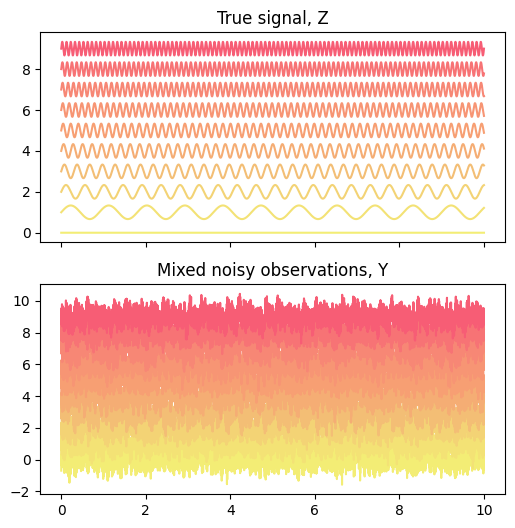

In [23]:
DIMS = 10
TIMES = 10000
frequencies = np.linspace(0,10,DIMS)
times = np.linspace(0,10,TIMES)

Z = np.sin(2*np.pi*frequencies[:,None]*times[None,:]).T

F = np.eye(DIMS)
Q = 0.01*np.eye(DIMS)
H = np.random.normal(0, 1, size=(DIMS,DIMS)) / np.sqrt(DIMS)
R = 10*np.eye(DIMS)
mu0 = np.zeros(DIMS)
sigma0 = np.eye(DIMS)

Y = Z @ H.T + np.random.normal(0, 1, size=(TIMES, DIMS))

fig, ax = plt.subplots(2,1,figsize=(6,6),sharex=True)
for i in range(DIMS):
    ax[0].plot(times, i+Z[:,i]/3, color=time_cmap(i/DIMS), alpha=1)
    ax[0].set_title("True signal, Z")
    ax[1].plot(times, i+Y[:,i]/3, color=time_cmap(i/DIMS), alpha=1)
    ax[1].set_title("Mixed noisy observations, Y")

In [24]:
# KALMAX (takes jax arrays)
kf_kalmax = KalmanFilter(
    dim_Z = DIMS,
    dim_Y = DIMS,
    F=jnp.array(F), 
    Q=jnp.array(Q),
    H=jnp.array(H),
    R=jnp.array(R),
    mu0=jnp.array(mu0),
    sigma0=jnp.array(sigma0),
    batch_size=1000, # batch size jax computation
    )

# PYKALMAN (takes numpy arrays)
from pykalman import KalmanFilter as PyKalmanFilter
kf_pykalman = PyKalmanFilter(
    transition_matrices = F,
    observation_matrices = H,
    transition_covariance = Q,
    observation_covariance = R,
    initial_state_mean = np.zeros(DIMS),
    initial_state_covariance = np.eye(DIMS),)

In [25]:
t0 = time()
means_pykalman, covs_pykalman = kf_pykalman.filter(Y)
print(f"PyKalman kalman filter took {time()-t0:.2f}s")

t0 = time()
means_kalmax, covs_kalmax = kf_kalmax.filter(jnp.array(Y))
print(f"KalMax kalman filter took {time()-t0:.2f}s")

PyKalman kalman filter took 0.71s
KalMax kalman filter took 0.30s


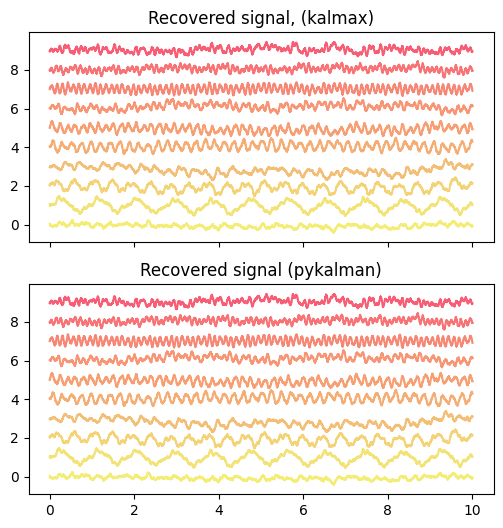

In [26]:
fig, ax = plt.subplots(2,1,figsize=(6,6),sharex=True)
for i in range(DIMS):
    ax[0].plot(times, i+means_kalmax[:,i]/3, color=time_cmap(i/DIMS), alpha=1)
    ax[0].set_title("Recovered signal, (kalmax)")
    ax[1].plot(times, i+means_pykalman[:,i]/3, color=time_cmap(i/DIMS), alpha=1)
    ax[1].set_title("Recovered signal (pykalman)")


In [27]:
# Run 10 times and make figure:
pykalman_times = []
kalmax_times = []

for _ in tqdm(range(10)):
    # PYKALMAN
    t0 = time()
    means_pykalman, covs_pykal = kf_pykalman.filter(Y)
    pykalman_times.append(time()-t0)


    # KALMAX
    t0 = time()
    means_kalmax, covs_kalmax = kf_kalmax.filter(jnp.array(Y))
    kalmax_times.append(time()-t0)

pykalman_times = np.array(pykalman_times) / TIMES
kalmax_times = np.array(kalmax_times) / TIMES

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


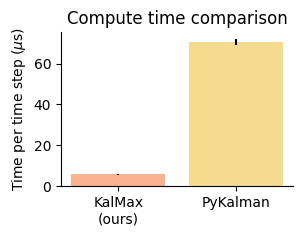

In [28]:
# Plot the results
fig, ax = plt.subplots(1,1,figsize=(3,2))
ax.bar([0,1], [10**6*kalmax_times.mean(), 10**6*pykalman_times.mean()], yerr=[10**6*kalmax_times.std(), 10**6*pykalman_times.std()], color=[time_cmap(0.5), time_cmap(0.2)], alpha=0.8,)
ax.set_xticks([0,1])
ax.set_xticklabels(["KalMax\n(ours)", "PyKalman"])
ax.set_ylabel(r"Time per time step ($\mu$s)")
ax.set_title("Compute time comparison") 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("figures/kalman_speed_comparison.png", dpi=300, bbox_inches='tight')

In [30]:
print(f"KalMax is {pykalman_times.mean()/kalmax_times.mean():.2f} times faster than PyKalman")

KalMax is 12.42 times faster than PyKalman
